In [66]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json

In [2]:
RANDOM_STATE = 42

# Read Data

In [3]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [194]:
read_query = make_read_query()

In [195]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,n_orders,n_order_items,revenue,purchased_categories,created_at,first_purchase_date,last_purchase_date,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value,segment,churn_flag
0,61226,30,M,United States,Mesquite,Search,0,0,0.00,[None],2021-12-06 08:35:00,NaT,NaT,None,None,None,None,None,None,None
1,15498,16,M,United States,Lincoln,Organic,1,1,25.00,[Sleep & Lounge],2024-01-14 04:24:00,2024-01-15 00:49:47,2024-01-15 00:49:47,None,None,None,None,None,None,None
2,41490,61,M,United States,Murrayville,Search,0,0,0.00,[None],2021-07-05 07:54:00,NaT,NaT,None,None,None,None,None,None,None
3,84974,18,M,China,Chengdu,Search,10,20,1035.38,"[Sweaters, Underwear, Pants, Socks, Outerwear ...",2021-06-17 17:55:00,2022-08-30 18:03:20,2024-01-09 16:21:17,None,None,None,None,None,None,None
4,98865,44,M,United States,Pharr,Search,1,1,259.99,[Suits & Sport Coats],2020-11-25 02:09:00,2023-11-29 23:31:26,2023-11-29 23:31:26,None,None,None,None,None,None,None


In [196]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    84011 non-null  int64         
 1   age                   84011 non-null  int64         
 2   gender                84011 non-null  object        
 3   country               84011 non-null  object        
 4   city                  84011 non-null  object        
 5   traffic_source        84011 non-null  object        
 6   n_orders              84011 non-null  int64         
 7   n_order_items         84011 non-null  int64         
 8   revenue               84011 non-null  float64       
 9   purchased_categories  84011 non-null  object        
 10  created_at            84011 non-null  datetime64[ns]
 11  first_purchase_date   69073 non-null  datetime64[ns]
 12  last_purchase_date    69073 non-null  datetime64[ns]
 13  active_days     

In [197]:
users_enriched.describe()

,id,age,n_orders,n_order_items,revenue,created_at,first_purchase_date,last_purchase_date
count,84011.000000,84011.000000,84011.000000,84011.000000,84011.000000,84011,69073,69073
mean,50059.769102,41.059897,4.412886,7.370951,439.676297,2021-06-14 10:42:19.902130432,2022-07-16 08:15:15.045710592,2023-01-26 22:31:06.887598848
min,1.000000,12.000000,0.000000,0.000000,0.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-07 01:23:18
25%,25094.500000,26.000000,1.000000,1.000000,22.000000,2020-02-20 04:11:00,2021-09-13 00:20:14,2022-08-05 16:38:29
50%,50125.000000,41.000000,2.000000,2.000000,108.400000,2021-05-23 03:56:00,2022-10-20 18:26:08,2023-06-03 21:57:37
75%,75022.500000,56.000000,5.000000,9.000000,455.980000,2022-09-24 04:51:30,2023-07-30 10:50:57,2023-11-09 01:02:14
max,100000.000000,70.000000,155.000000,270.000000,17963.080000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 18:02:23.533893
std,28861.594335,17.047718,6.805672,12.909895,867.696928,NaN,NaN,NaN


# Data Preparation

In [16]:
def split_customers(users_enriched):
    inactive_users = users_enriched.loc[users_enriched.n_orders==0]
    one_off_customers = users_enriched.loc[users_enriched.n_orders==1]
    repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1]
    return repeat_purchasers, one_off_customers, inactive_users

In [17]:
def make_lifetime_features(repeat_purchasers, now):
    df_lifetime = repeat_purchasers.copy()
    df_lifetime['active_days'] = (df_lifetime.last_purchase_date - df_lifetime.first_purchase_date).dt.days + 1
    df_lifetime['inactive_days'] = (now - df_lifetime.last_purchase_date).dt.days
    df_lifetime['avg_days_to_order'] = df_lifetime['active_days'] / (df_lifetime['n_orders'] - 1)
    df_lifetime['items_per_order'] = df_lifetime['n_order_items'] / df_lifetime['n_orders']
    df_lifetime['avg_order_value'] = df_lifetime['revenue'] / df_lifetime['n_orders']
    df_lifetime = df_lifetime[['active_days', 'inactive_days', 'avg_days_to_order', 'items_per_order', 'avg_order_value']]
    return df_lifetime

In [18]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

In [184]:
repeat_purchasers, one_off_customers, inactive_users = split_customers(users_enriched)
print('Repeat Purchasers:', repeat_purchasers.shape[0], 
      'One-Off Customers', one_off_customers.shape[0], 
      'Inactive Users', inactive_users.shape[0])

Repeat Purchasers: 42165 One-Off Customers 26908 Inactive Users 14938


In [21]:
now = users_enriched.last_purchase_date.max()
now

Timestamp('2024-01-21 18:02:23.533893')

In [22]:
df_lifetime = make_lifetime_features(repeat_purchasers, now)

In [23]:
df_lifetime.describe()

,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value
count,42165.000000,42165.000000,42165.000000,42165.000000,42165.000000
mean,319.315499,300.700747,61.094273,1.759730,104.590890
std,379.053120,326.430031,116.078998,0.765564,84.210452
min,1.000000,0.000000,0.052632,1.000000,4.470000
25%,4.000000,57.000000,2.500000,1.000000,51.835714
50%,166.000000,182.000000,22.666667,1.500000,82.567143
75%,524.000000,437.000000,69.800000,2.000000,129.730000
max,1785.000000,1840.000000,1732.000000,4.000000,1341.490000


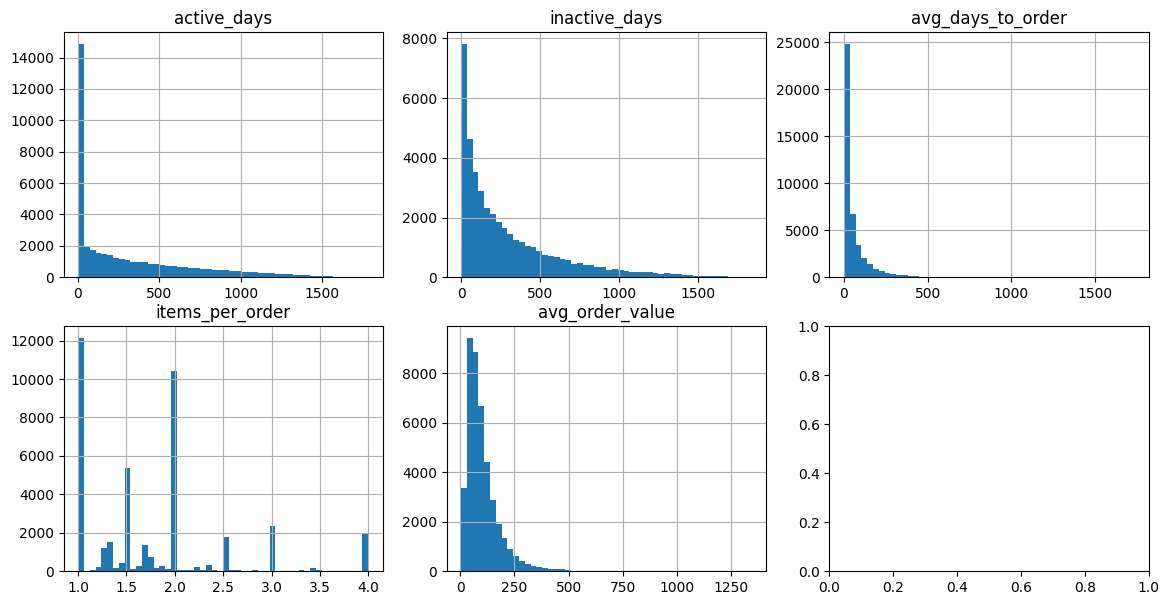

In [24]:
plot_histograms(df_lifetime, bins=50)

<Axes: >

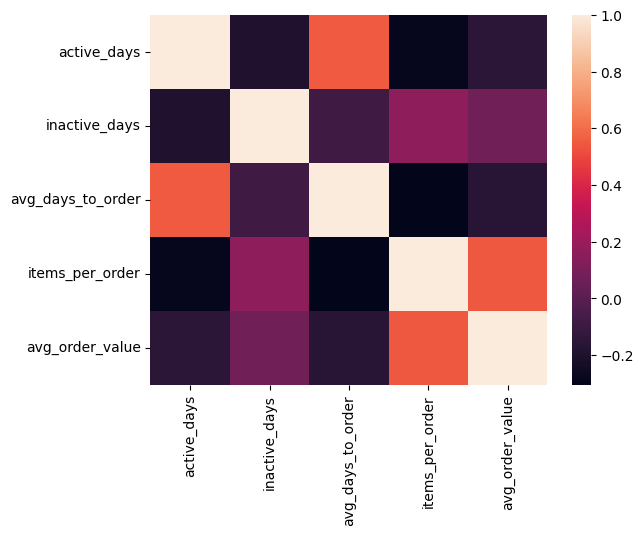

In [25]:
sns.heatmap(df_lifetime.corr())

# Clustering Repeat Purchasers

In [26]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []        
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)
        silhouette = silhouette_score(X, y)
        inertia = model.inertia_ if model_type == KMeans else None
        
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model, 
            'silhouette_score': silhouette,
            'inertia': inertia if inertia else cost
        }
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Inertia: {inertia}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [27]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(df_lifetime)

In [29]:
hyperparams = [{'n_clusters': i} for i in range(2, 11)]
df_results = search_clustering_hyperparams(KMeans, hyperparams, X, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.25827817484605237 | Inertia: 161632.75341282255
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.29281380648399163 | Inertia: 125879.37061942447
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.3088947970976837 | Inertia: 104059.56874176968
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.31158672792566583 | Inertia: 88024.74549606882
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.2982856052987544 | Inertia: 79535.0735879734
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.26575808161520315 | Inertia: 73981.8788007086
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.25644289751081256 | Inertia: 67344.33791807809
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.2569170912255367 | Inertia: 60733.291395871376
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.23367298880133397 | Inertia: 57364.309844311305


<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

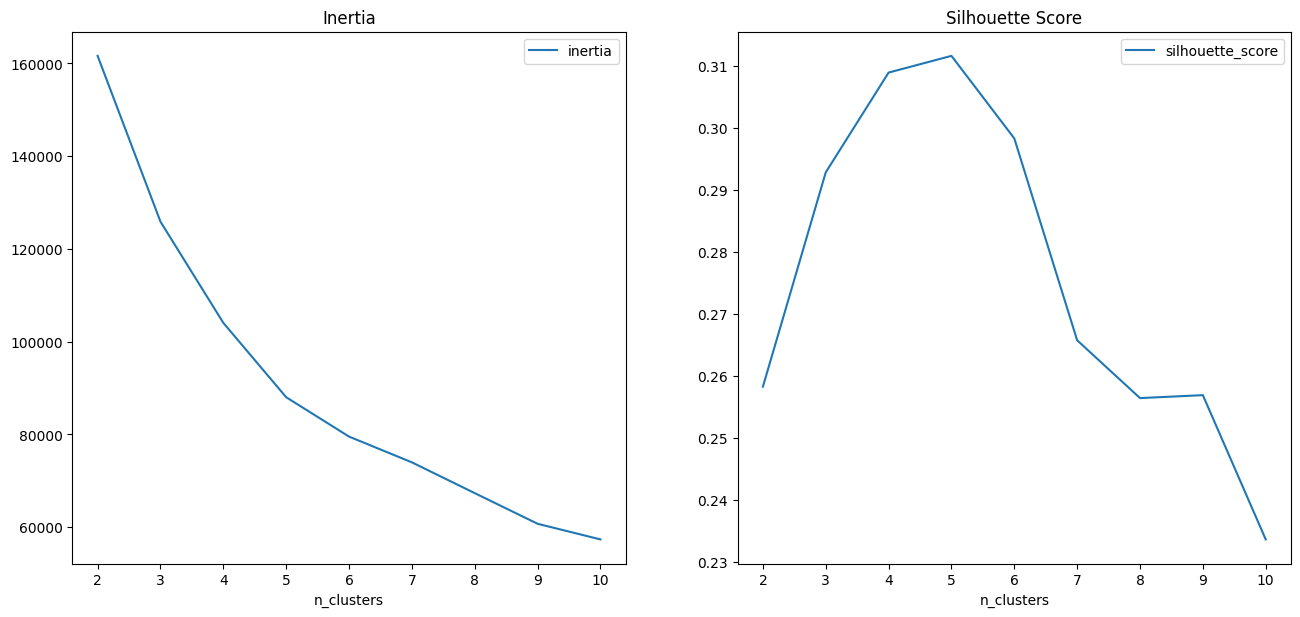

In [30]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
df_results.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
df_results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [72]:
model = df_results.loc[df_results.n_clusters==5, 'model'].iloc[0]
df_lifetime_cluster = df_lifetime.copy()
df_lifetime_cluster['cluster'] = model.labels_

In [73]:
cluster_centers = scaler.inverse_transform(model.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=df_lifetime.columns)
cluster_centers

,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value
0,947.830623,181.542005,696.134033,1.107272,67.652332
1,150.051681,159.385340,27.000305,1.528298,79.559322
2,856.664688,206.389454,131.350731,1.436842,83.017186
3,92.493219,307.821631,12.100713,3.065752,239.859929
4,127.915197,898.483007,25.976163,1.852469,94.969962


In [74]:
df_lifetime_cluster['cluster'].value_counts()

cluster
1    19428
2     9930
4     6238
3     5831
0      738
Name: count, dtype: int64

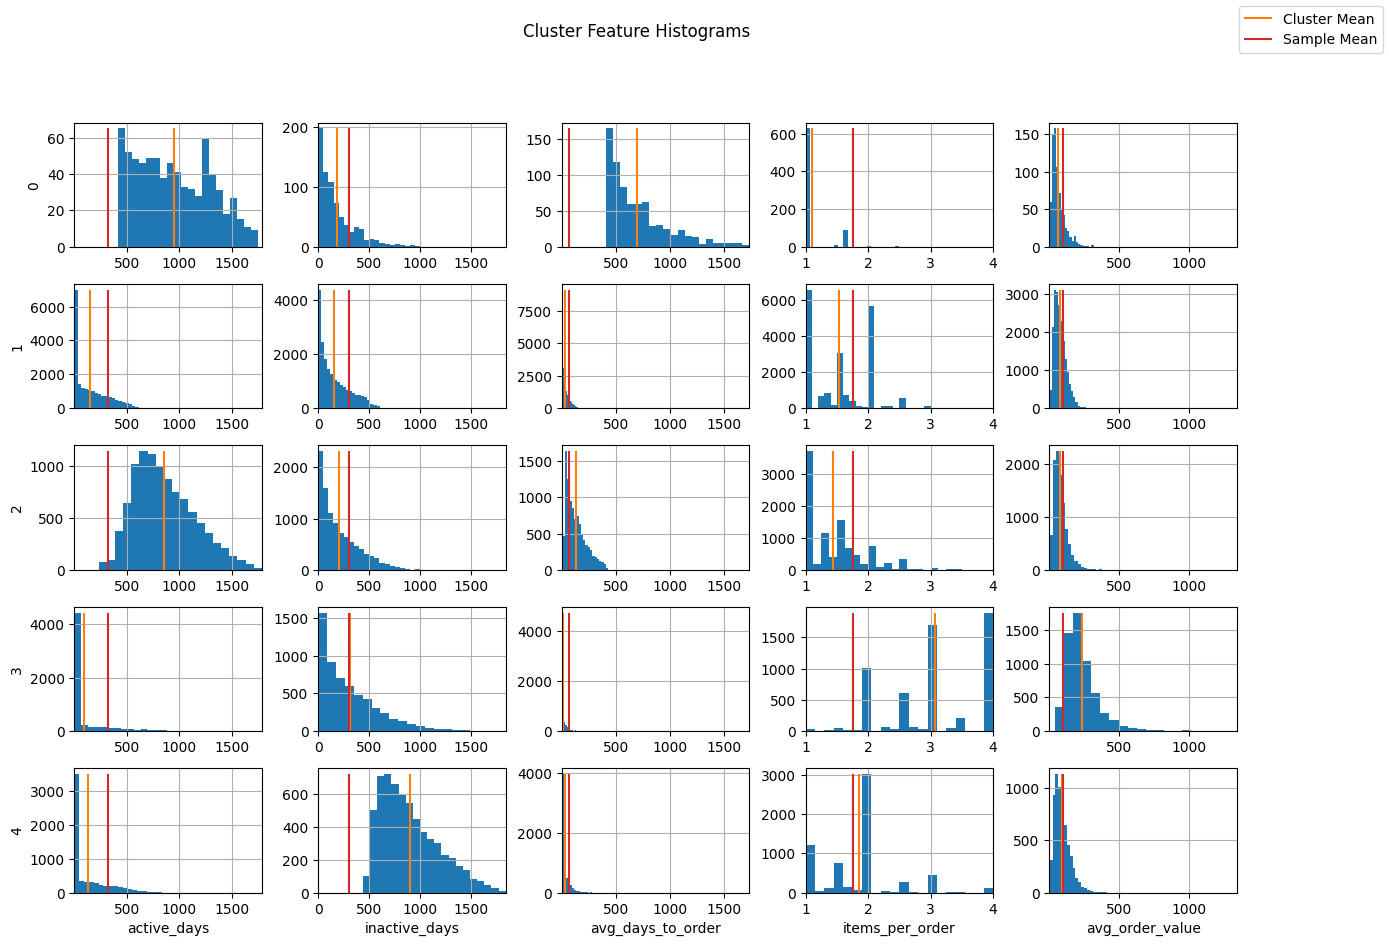

In [75]:
plot_clusters(df_lifetime, model.labels_)

In [76]:
print('Cluster Mean / Sample Mean:', df_lifetime_cluster.groupby('cluster').mean() / df_lifetime_cluster.drop(columns='cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', 'Cluster Mean:', df_lifetime_cluster.groupby('cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Std:', df_lifetime_cluster.groupby('cluster').std(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Min:', df_lifetime_cluster.groupby('cluster').min(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Max:', df_lifetime_cluster.groupby('cluster').max(), sep='\n')

Cluster Mean / Sample Mean:
         active_days  inactive_days  avg_days_to_order  items_per_order  \
cluster                                                                   
0           2.968320       0.603730          11.394424         0.629228   
1           0.470292       0.530037           0.442511         0.868245   
2           2.683696       0.686400           2.150158         0.816554   
3           0.289754       1.023327           0.198159         1.741938   
4           0.400592       2.987964           0.425182         1.052701   

         avg_order_value  
cluster                   
0               0.646828  
1               0.760563  
2               0.793719  
3               2.292165  
4               0.908014  

--------------------------------------------------------------------------------

Cluster Mean:
         active_days  inactive_days  avg_days_to_order  items_per_order  \
cluster                                                                   
0         

In [77]:
segment_map = {
    0: 'Loyals with Low Frequency',
    1: 'Frequents',
    2: 'Loyals',
    3: 'High AOV',
    4: 'Churned Long Ago'
}

In [78]:
df_lifetime_cluster['cluster'] = df_lifetime_cluster['cluster'].map(segment_map) 

In [79]:
df_lifetime_cluster

,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value,cluster
3,497,12,55.222222,2.000000,103.538000,Frequents
6,1144,12,228.800000,1.500000,37.475000,Loyals
7,74,82,24.666667,1.000000,45.750000,Frequents
8,658,15,94.000000,2.000000,151.570000,Loyals
10,88,1169,3.826087,2.666667,137.760000,Churned Long Ago
...,...,...,...,...,...,...
84000,305,73,38.125000,1.000000,142.663333,Frequents
84002,192,476,38.400000,1.500000,71.975000,Frequents
84004,17,50,2.428571,2.000000,390.680000,High AOV
84006,592,892,118.400000,1.500000,42.270000,Churned Long Ago


In [80]:
df_lifetime_cluster.cluster.value_counts()

cluster
Frequents                    19428
Loyals                        9930
Churned Long Ago              6238
High AOV                      5831
Loyals with Low Frequency      738
Name: count, dtype: int64

# Flag Potentially Churned Customers

In [116]:
def add_churn_flags(df_lifetime_cluster):
    cluster_churn_limits = df_lifetime_cluster.groupby('cluster').avg_days_to_order.quantile(0.9).to_frame('churn_limit')
    cluster_upcoming_churn_limits = df_lifetime_cluster.groupby('cluster').avg_days_to_order.quantile(0.75).to_frame('upcoming_churn_limit')
    df_lifetime_cluster = df_lifetime_cluster.join(cluster_churn_limits, on='cluster')\
                                             .join(cluster_upcoming_churn_limits, on='cluster')
    upcoming_churn_idx = df_lifetime_cluster['inactive_days'] > df_lifetime_cluster['upcoming_churn_limit']
    churn_idx = df_lifetime_cluster['inactive_days'] > df_lifetime_cluster['churn_limit']
    df_lifetime_cluster.loc[upcoming_churn_idx, 'churn_flag'] = 'Upcoming Churn'
    df_lifetime_cluster.loc[churn_idx, 'churn_flag'] = 'Churned'
    return df_lifetime_cluster

In [117]:
df_lifetime_flagged = add_churn_flags(df_lifetime_cluster)

In [118]:
df_lifetime_flagged.groupby('cluster')['churn_flag'].value_counts()

cluster                    churn_flag    
Churned Long Ago           Churned            6238
Frequents                  Churned           11687
                           Upcoming Churn     2608
High AOV                   Churned            4914
                           Upcoming Churn      646
Loyals                     Churned            3045
                           Upcoming Churn     1263
Loyals with Low Frequency  Upcoming Churn        8
Name: count, dtype: int64

# Concat Data

In [185]:
def concat_lifetime_cols(repeat_purchasers, df_lifetime_flagged):
    return  pd.concat([repeat_purchasers, 
                       df_lifetime_flagged.drop(columns=['churn_limit', 'upcoming_churn_limit'])],
                      axis=1)

In [186]:
def concat_customers(repeat_purchasers_clustered, one_off_customers, inactive_users):
    repeat_purchasers_clustered = repeat_purchasers_clustered.rename(columns={'cluster': 'segment'})
    one_off_customers, inactive_users = one_off_customers.copy(), inactive_users.copy()
    one_off_customers['segment'] = 'One-Off Customers'
    inactive_users['segment'] = 'Never Ordered'
    customers_segmented = pd.concat([repeat_purchasers_clustered, one_off_customers, inactive_users])\
                            .sort_values('created_at')
    return customers_segmented

In [187]:
repeat_purchasers_clustered = concat_lifetime_cols(repeat_purchasers, df_lifetime_flagged)

one_off_customers_lifetime = make_lifetime_features(one_off_customers, now)
one_off_customers_ = one_off_customers.join(one_off_customers_lifetime)
one_off_customers_.loc[one_off_customers_.avg_days_to_order==np.inf, 'avg_days_to_order'] = None

customers_segmented = concat_customers(repeat_purchasers_clustered, one_off_customers_, inactive_users)

In [193]:
customers_segmented

,id,age,gender,country,city,traffic_source,n_orders,n_order_items,revenue,purchased_categories,created_at,first_purchase_date,last_purchase_date,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value,segment,churn_flag
44613,56219,60,F,United States,Philadelphia,Facebook,1,1,74.99,[Jeans],2019-01-02 00:06:00.000000,2021-05-27 23:07:12.000000,2021-05-27 23:07:12.000000,1.0,968.0,NaN,1.0,74.990,One-Off Customers,NaN
19977,72034,70,F,South Korea,Seoul,Organic,4,4,886.00,"[Outerwear & Coats, Intimates, None]",2019-01-02 00:36:00.000000,2021-07-30 12:35:12.000000,2023-04-21 14:50:59.000000,631.0,275.0,210.333333,1.0,221.500,Loyals,Churned
73294,21731,65,F,China,Harbin,Email,4,16,975.76,"[Maternity, Accessories, Tops & Tees, Blazers ...",2019-01-02 01:47:00.000000,2023-09-17 22:23:37.000000,2023-09-20 23:24:58.000000,4.0,122.0,1.333333,4.0,243.940,High AOV,Churned
52316,39594,17,M,China,Shenzhen,Search,4,4,143.90,"[Fashion Hoodies & Sweatshirts, Accessories]",2019-01-02 03:00:00.000000,2019-02-11 03:06:43.000000,2019-10-25 02:29:03.000000,256.0,1549.0,85.333333,1.0,35.975,Churned Long Ago,Churned
47225,2000,30,F,China,Hefei,Search,0,0,0.00,[None],2019-01-02 03:19:00.000000,NaT,NaT,NaN,NaN,NaN,NaN,NaN,Never Ordered,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83511,85277,51,M,China,Liaoyang,Email,2,4,245.96,"[Underwear, Pants]",2024-01-16 19:27:12.181669,2024-01-18 17:26:04.181669,2024-01-20 18:48:22.181669,3.0,0.0,3.000000,2.0,122.980,Frequents,NaN
19465,78257,53,M,South Korea,Incheon Metropolitan City,Display,8,16,1389.96,"[Sleep & Lounge, Active, Tops & Tees, Sleep & ...",2024-01-16 19:31:18.782754,2024-01-17 16:18:09.782754,2024-01-21 17:46:48.782754,5.0,0.0,0.714286,2.0,173.745,Frequents,NaN
32716,47322,53,M,United States,Monroe,Search,1,1,34.97,[Sleep & Lounge],2024-01-16 19:31:33.029124,2024-01-17 16:59:48.029124,2024-01-17 16:59:48.029124,1.0,4.0,NaN,1.0,34.970,One-Off Customers,NaN
5060,78978,27,F,China,Zhoukou,Email,2,4,81.88,"[Leggings, Tops & Tees]",2024-01-16 19:41:42.220676,2024-01-18 17:54:37.220676,2024-01-21 15:53:40.220676,3.0,0.0,3.000000,2.0,40.940,Frequents,NaN


In [177]:
customers_segmented.groupby(['cluster'])['id'].count()

cluster
Churned Long Ago              6238
Frequents                    19428
High AOV                      5831
Loyals                        9930
Loyals with Low Frequency      738
Never Ordered                14938
One-Off Customers            26908
Name: id, dtype: int64

# Save Pipeline 

In [102]:
pipe = Pipeline([('scaler', scaler), ('kmeans', model)])

In [103]:
# with open('../models/cust_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(pipe, f)

In [104]:
with open('../models/cust_segment_pipe.pkl', 'rb') as f:
    pipe_loaded = pkl.load(f)

In [105]:
y = pipe_loaded.predict(df_lifetime)
(y == model.labels_).all()

np.True_

In [189]:
with open('../models/cust_segment_map.json', 'w') as f:
    json.dump(segment_map, f)

In [190]:
with open('../models/cust_segment_map.json', 'r') as f:
    segment_map_ = json.load(f)

In [191]:
segment_map_

{'0': 'Loyals with Low Frequency',
 '1': 'Frequents',
 '2': 'Loyals',
 '3': 'High AOV',
 '4': 'Churned Long Ago'}